# Tutorial 2: Uncertainty Experiments with the PyEOSim Framework
#### Joe Fennell | September 2024

*under construction!*

In [1]:
Sentinel_2_geometry = {
    'SOLAR_ZENITH_ANGLE': 29.9793624960938,
    'VIEW_ZENITH_ANGLE': 3.06889419958891,
    'SOLAR_AZIMUTH_ANGLE': 157.124519128112,
    'VIEW_AZIMUTH_ANGLE': 173.991655773712
}

In [2]:
import xarray

S2A_L1C = xarray.open_dataset('data/Milton_Keynes_Sentinel2_L1C.nc')
S2A_L2A = xarray.open_dataset('data/Milton_Keynes_Sentinel2_L1C.nc')

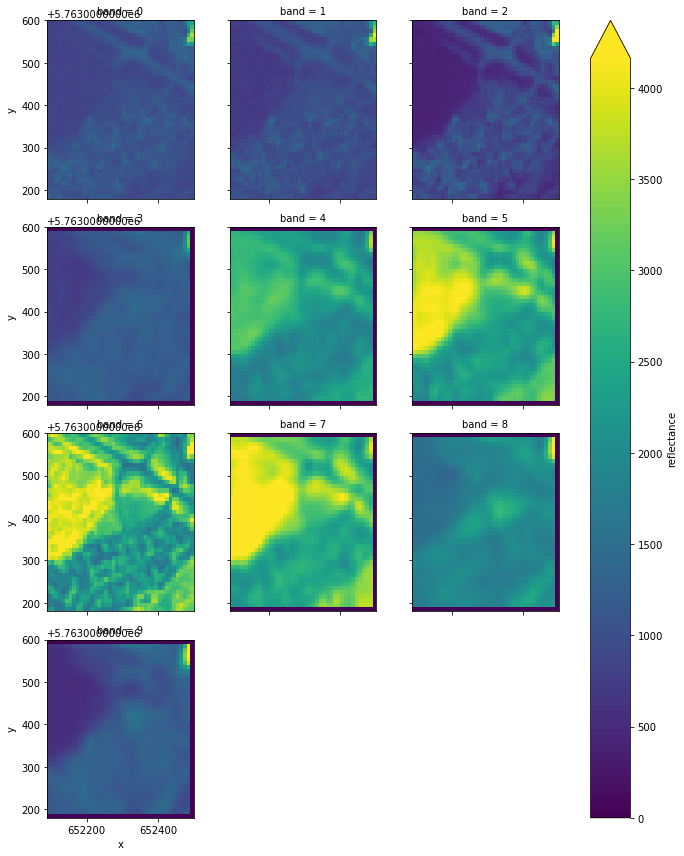

In [3]:
S2A_L1C['reflectance'].plot(col='band', col_wrap=3, robust=True)

In [ ]:
S2A_L2A['reflectance'].plot(col='band', col_wrap=3, robust=True)